In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Sequence population is repeat sequences.

Look at input and output participation for each cell type:
- What cell types are the sequences composed of (output) (what are the cell types of the sequence participants)
- What cell types are the sequences found in (input) (what is the cell type of the dendrite)

Pie chart, these metrics compared to frequency of cell type in the entire dataset

Interpretation:
- Sequence participation vs pre synaptic distribution:
    - If match:
        - No cell type is more likely to form a synapse that is part of a sequence than any other cell type
- Sequence synapse decoding vs post synaptic distribution:
    - If match:
        - Dendrites of all cell types decode sequences at equal rates


In [4]:
# Find the longest common subsequence between two given strings, returning the longest common string
def lcs(s1, s2):
    m = [[0] * (1 + len(s2)) for i in range(1 + len(s1))]
    longest, x_longest = 0, 0
    for x in range(1, 1 + len(s1)):
        for y in range(1, 1 + len(s2)):
            if s1[x - 1] == s2[y - 1]:
                m[x][y] = m[x - 1][y - 1] + 1
                if m[x][y] > longest:
                    longest = m[x][y]
                    x_longest = x
            else:
                m[x][y] = 0
    return s1[x_longest - longest: x_longest]

In [64]:
# Read in the data
all_synapses = pd.read_csv('synapses_w_ids.csv', index_col=0)
print(len(all_synapses))
display(all_synapses.head())

all_cells = pd.read_csv('cells_no_repeats.csv', index_col=0)
all_cells.set_index('pt_root_id', inplace=True)
print(len(all_cells))
display(all_cells.head())

5421809


,pre_pt_root_id,post_pt_root_id,size,cell_type_pre,cb_x_pre,cb_y_pre,cb_z_pre,cell_type_post,cb_x_post,cb_y_post,cb_z_post,cb_x_diff,cb_y_diff,cb_z_diff,ctr_pt_x,ctr_pt_y,ctr_pt_z,synapse_id
0,864691135564683351,864691136811959667,960,23P,557.248,570.560,732.52,23P,791.744,483.968,780.44,-234.496,86.592,-47.92,637.608,371.352,720.20,0
1,864691135614119115,864691135508912649,7576,23P,774.720,504.960,895.68,23P,807.936,459.584,870.28,-33.216,45.376,25.40,805.376,488.376,863.60,1
3,864691135113147801,864691136022555784,684,23P,883.072,451.456,817.84,23P,851.520,483.840,759.96,31.552,-32.384,57.88,858.328,516.648,775.88,3
4,864691135194393642,864691135341362885,23172,23P,781.248,449.984,696.88,23P,798.720,465.152,758.56,-17.472,-15.168,-61.68,789.400,478.040,691.00,4
5,864691136272938174,864691135683554546,3660,23P,762.368,473.792,773.68,23P,820.352,446.784,719.08,-57.984,27.008,54.60,756.624,440.928,710.60,5


56209


,cell_type,pt_x,pt_y,pt_z
pt_root_id,,,,
864691135639004475,23P,71136,110528,20220
864691135771677771,23P,72576,108656,20291
864691135864089470,23P,79632,121456,16754
864691135560505569,23P,80128,124000,16563
864691136315868311,23P,80144,126928,16622


In [63]:
lcs_dict = pd.read_pickle('sequences/similarity/top_k_storage/s_30_e_100_.pkl')
char_to_pt_root_id = pd.read_pickle('sequences/char_to_pt_root_id.pkl')

In [6]:
repeat_sequences = []
subseq_appearances = {}
thresh = 3
for length, lcs_comps in lcs_dict.items():
    for seq, comps in lcs_comps:
        for comp in comps:
            if comp[1] >= thresh:
                subseq = lcs(seq, comp[0])
                appearance = subseq_appearances.setdefault(subseq, 1)
                repeat_sequences.append(subseq)
                subseq_appearances[subseq] = appearance + 1

repeated_sequences = list(set(repeat_sequences))

In [7]:
print(len(repeated_sequences))

681


1. Plot the cell count for each cell type in a pie chart
2. Plot the sequence participation for each cell type in a pie chart
3. Plot the sequence synapse decoding for each cell type in a pie chart

"""

In [81]:
# Given a list of cell count data and titles, plot the cell count for each cell type for each data in a separate pie chart
# Arrange the subplots in a grid wit the number of rows and columns equal to the number of data
def plot_pie_charts(data, titles, rows, cols, save_path=None):
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    for i in range(len(data)):
        if rows == 1:
            axs[i].pie(data[i][0], labels=data[i][1], autopct='%1.1f%%', startangle=90)
            axs[i].axis('equal')
            axs[i].set_title(titles[i])
        else:
            axs[i // cols, i % cols].pie(data[i][0], labels=data[i][1], autopct='%1.1f%%', startangle=90)
            axs[i // cols, i % cols].axis('equal')
            axs[i // cols, i % cols].set_title(titles[i])
    if save_path:
        plt.savefig(save_path)
    plt.show()

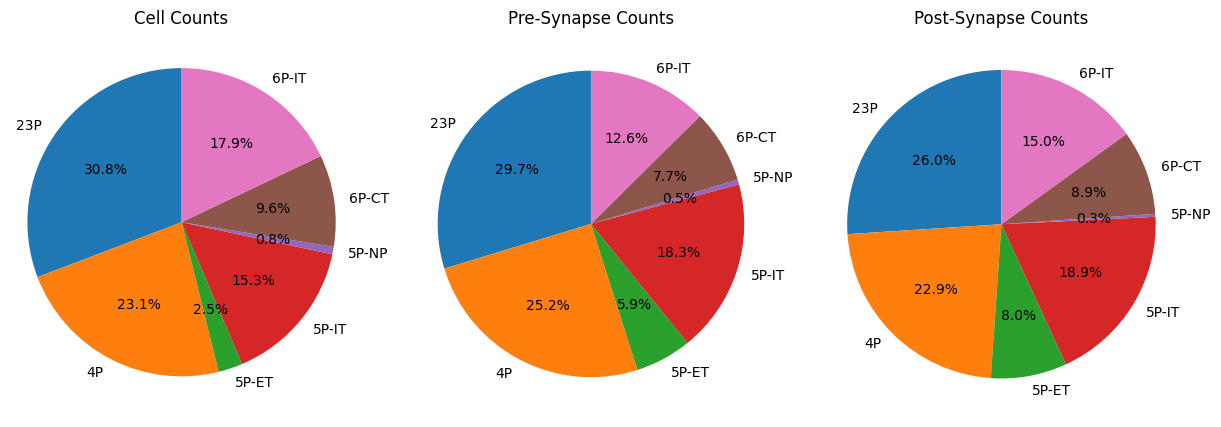

In [83]:
cell_counts_by_ct = all_cells['cell_type'].value_counts().sort_index()
pre_ct_synapse_counts = all_synapses['cell_type_pre'].value_counts().sort_index()
post_ct_synapse_counts = all_synapses['cell_type_post'].value_counts().sort_index()

data = [cell_counts_by_ct, pre_ct_synapse_counts, post_ct_synapse_counts]
titles = ['Cell Counts', 'Pre-Synapse Counts', 'Post-Synapse Counts']

plot_pie_charts(list(zip(data, [f.index for f in data])), titles, 1, 3, save_path='measured_counts.png')

In [71]:
sequence_participants = {cell_counts_by_ct.index[i]: 0 for i in range(len(cell_counts_by_ct))}
for seq in repeated_sequences:
    types = [str(all_cells.loc[char_to_pt_root_id[c], 'cell_type']) for c in seq]
    for t in types:
        sequence_participants[t] += 1

In [77]:
print(sequence_participants)

{'23P': 612, '4P': 537, '5P-ET': 206, '5P-IT': 325, '5P-NP': 11, '6P-CT': 145, '6P-IT': 209}


In [75]:
encoded_sequences_dict = pd.read_pickle('sequences/encoded_dict.pkl')

In [76]:
subseq_to_cells = {}
for subseq in repeated_sequences:
    cells = subseq_to_cells.setdefault(subseq, [])
    for cell, seqs in encoded_sequences_dict.items():
        for seq in seqs:
            if subseq in seq:
                cells.append(cell)

In [78]:
sequence_decoders = {cell_counts_by_ct.index[i]: 0 for i in range(len(cell_counts_by_ct))}
for subseq, cells in subseq_to_cells.items():
    types = [str(all_cells.loc[c, 'cell_type']) for c in cells]
    for t in types:
        sequence_decoders[t] += 1

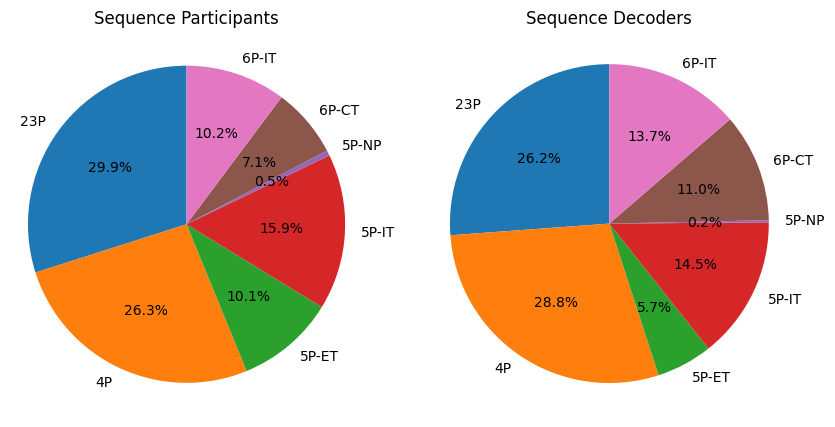

In [84]:
labels = cell_counts_by_ct.index
plot_pie_charts(list(zip([list(sequence_participants.values()), list(sequence_decoders.values())], [labels, labels])), ['Sequence Participants', 'Sequence Decoders'], 1, 2, save_path='sequence_participants_decoders.png')

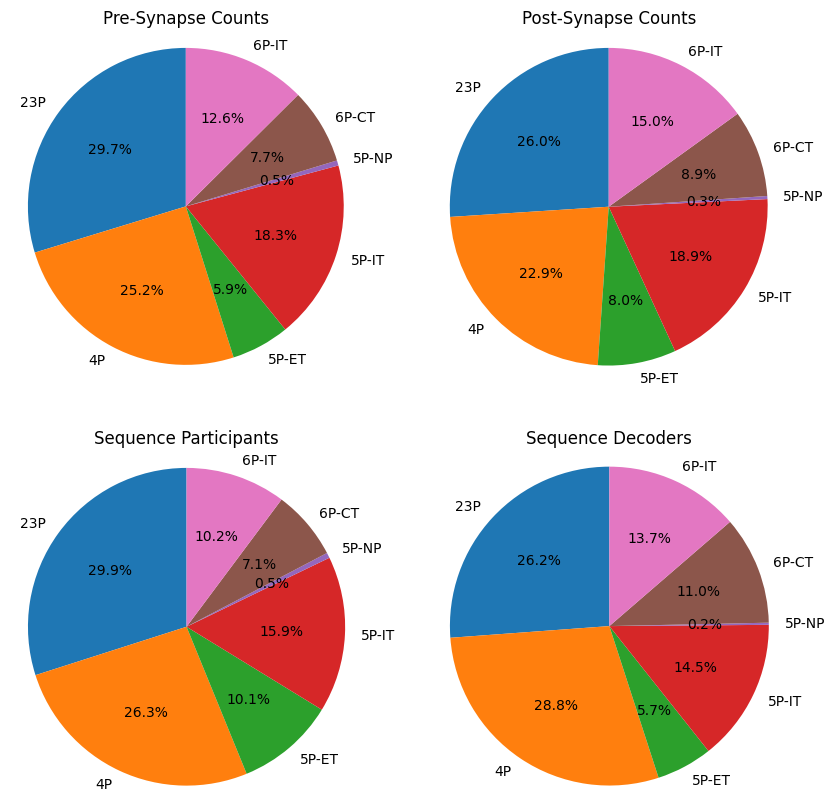

In [87]:
data1 = [pre_ct_synapse_counts, post_ct_synapse_counts]
titles1 = ['Pre-Synapse Counts', 'Post-Synapse Counts']

combined_data = list(zip(data1, [f.index for f in data1])) + list(zip([list(sequence_participants.values()), list(sequence_decoders.values())], [labels, labels]))
combined_titles = titles1 + ['Sequence Participants', 'Sequence Decoders']
plot_pie_charts(combined_data, combined_titles, 2, 2, save_path='plots/synapse_frequency_comps.png')